In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import utils as utils

In [2]:
train_path = 'train.csv'
val_path = 'val.csv'

train_data = pd.read_csv(train_path)
train_data['label'] = (train_data['label'] == 'self.SuicideWatch').astype(int)

val_data=pd.read_csv(val_path)
val_data['label'] = (val_data['label'] == 'self.SuicideWatch').astype(int)

train_data.describe()

,label
count,45706.000000
mean,0.187459
std,0.390284
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [3]:
# get majority and minority classes
df_majority = train_data[train_data['label'] == 0]
df_minority = train_data[train_data['label'] == 1]

# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# downsample majority class
df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=len(df_minority),
                                    random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac=1, random_state=42)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

In [7]:
def load_glove_vectors(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Path to the GloVe file
glove_path = 'glove.6B.100d.txt'  # Adjust this path to where you've saved your GloVe data
embeddings_index = load_glove_vectors(glove_path)

In [8]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_upsampled['text'])

#saving the tokenizer
with open('LSTMtokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert text to sequences and pad them
max_length = max([len(s.split()) for s in df_upsampled['text']])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(df_upsampled['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])

X_data = pad_sequences(train_sequences, maxlen=max_length)
X_val = pad_sequences(val_sequences, maxlen=max_length)

y_val = val_data['label']
#split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_data, df_upsampled['label'],test_size=0.2, random_state=42)

In [11]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

ValueError: could not broadcast input array from shape (44,) into shape (100,)

In [10]:
def build_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
        LSTM(210, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
results = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}

#loop through each percentage
for fraction in [0.999]:
    model = build_model()  # Recreate the model for each iteration
    partial_X_train, _, partial_y_train, _ = train_test_split(X_train, y_train,train_size=fraction)
    model.fit(partial_X_train, partial_y_train, epochs=10, batch_size=64, verbose=1,validation_data=(X_val, y_val))

     # Predict on X_test
    y_pred_prob = model.predict(X_test)
    y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

    # Calculate metrics
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    accuracy = accuracy_score(y_test, y_pred_class)

    # Store metrics
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['accuracy'].append(accuracy)

Epoch 1/8
 13/928 [..............................] - ETA: 4:04 - loss: 0.6860 - accuracy: 0.5421

KeyboardInterrupt: 

In [18]:
 # Calculate metrics
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)

    # Store metrics
results['precision'].append(precision)
results['recall'].append(recall)
results['f1'].append(f1)
results['accuracy'].append(accuracy)

print(results)

{'precision': [0.8941065662002153, 0.8941065662002153], 'recall': [0.8944676268676807, 0.8944676268676807], 'f1': [0.8942870600901689, 0.8942870600901689], 'accuracy': [0.8942514808831449, 0.8942514808831449]}


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

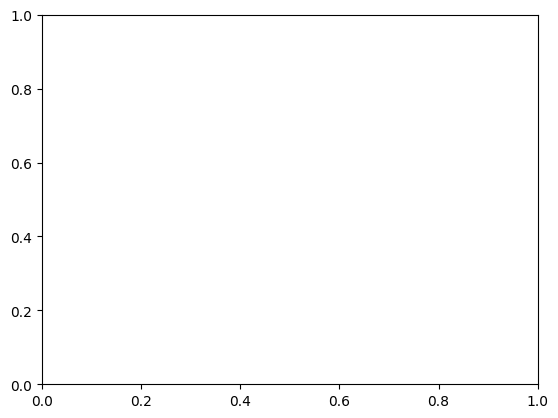

In [17]:
utils.create_graph([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], results, 'Long-Short Term Memory network', 'LSTM.png')

In [ ]:
model.save('LSTMBinary.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
